import libraries

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs

prepare the data

In [ ]:
X, Y = make_blobs(2000, 2, centers = 4, cluster_std = 1.5, random_state = 42)
dataset = pd.DataFrame(np.concatenate((X, np.expand_dims(Y, axis = 1)), axis = 1), columns = ['X1', 'X2', 'label'])
dataset.head()

,X1,X2,label
0,4.447073,-0.849604,1.0
1,5.452073,3.111902,1.0
2,-8.906239,-8.863797,2.0
3,-8.919185,5.850068,3.0
4,-5.850998,6.075431,3.0


visualise data

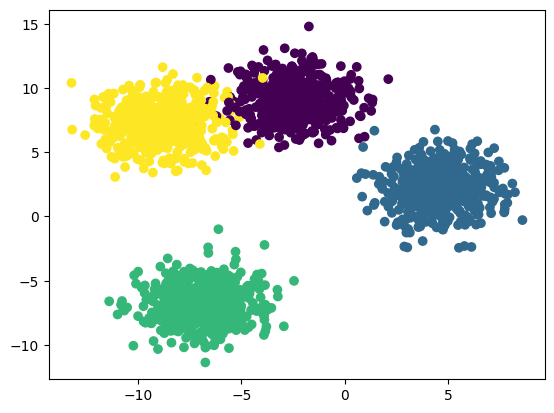

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c = Y)

turn data into tensors

In [ ]:
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.long)
X.shape, Y.shape

(torch.Size([2000, 2]), torch.Size([2000]))

split the data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
#Y_train, Y_test = Y_train.unsqueeze(dim = 1), Y_test.unsqueeze(dim = 1)
X_train.shape, X_test.shape, Y_train.shape

(torch.Size([1600, 2]), torch.Size([400, 2]), torch.Size([1600]))

create model

In [ ]:
'''class CircleModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear_layer1 = nn.Linear(in_features = 2, out_features = 5)
    self.linear_layer2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, X):
    return self.linear_layer2(self.linear_layer1(X))
'''

model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 10),
    nn.ReLU(),
    nn.Linear(in_features = 10, out_features = 10),
    nn.ReLU(),
    nn.Linear(in_features = 10, out_features = 4),
)

define accuracy

In [ ]:
def accuracy(y_pred, y_true):
  correct_count = torch.eq(y_pred, y_true).sum().item()
  return correct_count / len(y_pred) * 100

train the model

In [ ]:
from sklearn.metrics import accuracy_score

epochs = 70

loss_fn = nn.CrossEntropyLoss() # BCEWithLogitsLoss in case of binary

optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.01)

model_accuracy = []

epochs_array = []

for epoch in range(epochs):

  model_0.train()

  Y_preds = model_0(X_train)

  loss_value = loss_fn(Y_preds, Y_train)

  optimizer.zero_grad()

  loss_value.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    y_preds_train = model_0(X_train)
    accuracy = accuracy_score(Y_train, torch.argmax(torch.softmax(y_preds_train, dim = 1), dim = 1)) # torch.sigmoid for binary
    model_accuracy.append(accuracy)
    epochs_array.append(epoch)


model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6517,  0.8752],
                      [-0.7108, -0.1939],
                      [-0.6190, -0.8725],
                      [-0.4282, -0.4373],
                      [ 1.0392,  0.1906],
                      [-0.8848,  0.4738],
                      [-0.0852, -0.2695],
                      [-0.1899, -0.8391],
                      [-0.2916, -0.5191],
                      [-0.1938,  0.4292]])),
             ('0.bias',
              tensor([ 0.2117, -0.0212,  0.2191,  0.7858, -0.2042,  0.5255, -0.2369,  0.1718,
                      -0.3196, -0.4125])),
             ('2.weight',
              tensor([[-0.0631,  0.2620, -0.3083, -0.2323, -0.1561,  0.3901, -0.0337, -0.0192,
                        0.0424,  0.6554],
                      [ 0.6015, -0.6798,  0.4590, -0.4270,  0.5471, -0.0147,  0.3103,  0.3464,
                       -0.5224,  0.1388],
                      [ 0.3212, -0.3433,  0.0521,  0.0174, -0.1972,  0.4870, -0.0214, -0.2

visualise accuracy during training

Text(0, 0.5, 'accuracy')

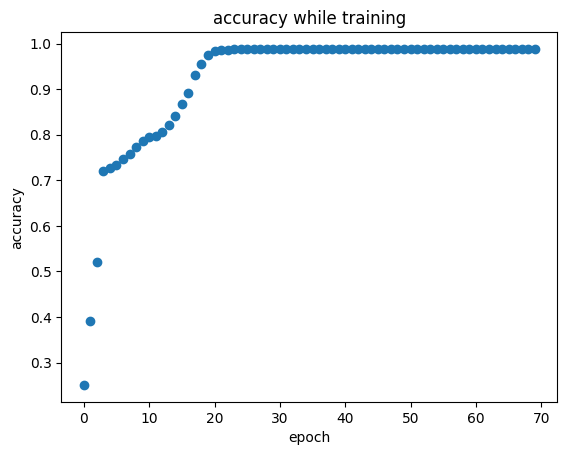

In [ ]:
plt.scatter(epochs_array, model_accuracy)
plt.title('accuracy while training')
plt.xlabel('epoch')
plt.ylabel('accuracy')

make predictions

In [ ]:
model_0.eval()

with torch.inference_mode():

  Y_preds_test = model_0(X_test)
  accuracy_score = accuracy_score(Y_test, torch.argmax(torch.softmax(Y_preds_test, dim = 1), dim = 1)) * 100
  print(accuracy_score)

99.5


plot the decision boundary

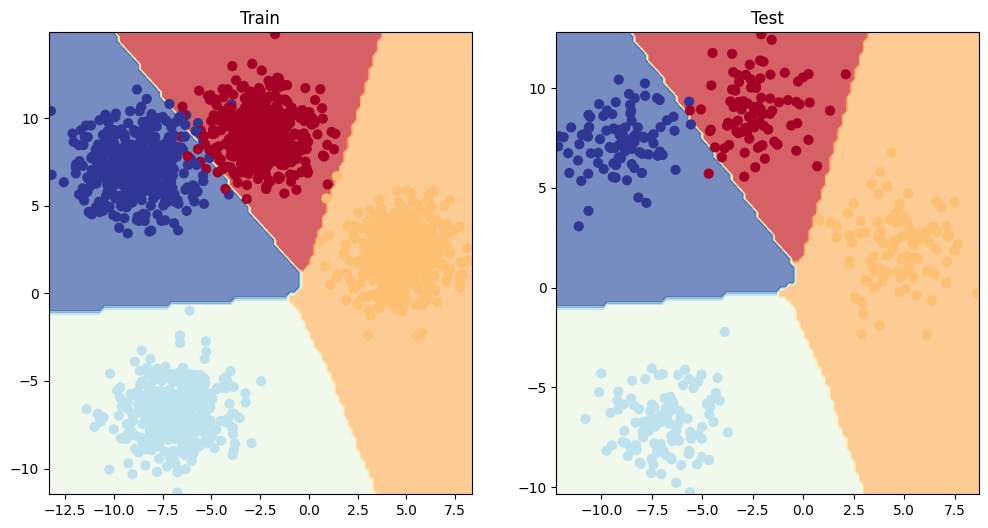

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):


    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, Y_test)